[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/ryanfobel/gridwatch-history/main)

# Download operational data about the Ontario grid

We can use this data to reverse-engineer the models used by gridwatch.ca and co2signal.com (e.g., see [issue #1](https://github.com/ryanfobel/gridwatch-history/issues/1) on github).

In [1]:
%load_ext autoreload
%autoreload 2


import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

%matplotlib inline



import os
import sys
import json

sys.path.insert(0, os.path.join(".."))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from cycler import cycler

from pipelines import ieso

%matplotlib inline

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
def scale_rgb(colormap):
    return [(r / 255., g / 255., b / 255.) for r, g, b in colormap]

light = scale_rgb([
    (136, 189, 230),
    (251, 178, 88),
    (144, 205, 151),
    (246, 170, 201),
    (191, 165, 84),
    (188, 153, 199),
    (237, 221, 70),
    (240, 126, 110),
    (140, 140, 140)])

rcParams.update({
    'figure.figsize': (12, 10),
    'font.size': 16,
    'axes.prop_cycle': cycler('color', light)
})

In [2]:
from pipelines.ieso.CA import fetch_production, fetch_production_by_fuel, fetch_price
import arrow

now = arrow.now()

In [3]:
data = fetch_price(target_datetime=now)
print(len(data))
data

17


[{'datetime': datetime.datetime(2023, 12, 19, 1, 0, tzinfo=datetime.timezone(datetime.timedelta(days=-1, seconds=68400), 'UTC-5')),
  'price': 12.73,
  'currency': 'CAD',
  'source': 'ieso.ca',
  'zoneKey': 'CA-ON'},
 {'datetime': datetime.datetime(2023, 12, 19, 2, 0, tzinfo=datetime.timezone(datetime.timedelta(days=-1, seconds=68400), 'UTC-5')),
  'price': 14.24,
  'currency': 'CAD',
  'source': 'ieso.ca',
  'zoneKey': 'CA-ON'},
 {'datetime': datetime.datetime(2023, 12, 19, 3, 0, tzinfo=datetime.timezone(datetime.timedelta(days=-1, seconds=68400), 'UTC-5')),
  'price': 13.37,
  'currency': 'CAD',
  'source': 'ieso.ca',
  'zoneKey': 'CA-ON'},
 {'datetime': datetime.datetime(2023, 12, 19, 4, 0, tzinfo=datetime.timezone(datetime.timedelta(days=-1, seconds=68400), 'UTC-5')),
  'price': 14.07,
  'currency': 'CAD',
  'source': 'ieso.ca',
  'zoneKey': 'CA-ON'},
 {'datetime': datetime.datetime(2023, 12, 19, 5, 0, tzinfo=datetime.timezone(datetime.timedelta(days=-1, seconds=68400), 'UTC-5')),


In [4]:
# 3-months of historical data available via IESO xml feed [1]
# 1. https://github.com/electricitymaps/electricitymaps-contrib/blob/master/parsers/CA_ON.py)
df = fetch_production(target_datetime=now.shift(months=-3).datetime)
print(len(df))
df

4320


,name,fuel,dt,production
0,BRUCEA-G1,nuclear,2023-09-19 01:00:00-05:00,798.0
1,BRUCEA-G1,nuclear,2023-09-19 02:00:00-05:00,799.0
2,BRUCEA-G1,nuclear,2023-09-19 03:00:00-05:00,799.0
3,BRUCEA-G1,nuclear,2023-09-19 04:00:00-05:00,799.0
4,BRUCEA-G1,nuclear,2023-09-19 05:00:00-05:00,799.0
...,...,...,...,...
4315,TBAYBOWATER CTS,biomass,2023-09-19 20:00:00-05:00,0.0
4316,TBAYBOWATER CTS,biomass,2023-09-19 21:00:00-05:00,0.0
4317,TBAYBOWATER CTS,biomass,2023-09-19 22:00:00-05:00,0.0
4318,TBAYBOWATER CTS,biomass,2023-09-19 23:00:00-05:00,0.0


In [5]:
df = fetch_production(target_datetime=now)
df_by_source = df.groupby(
    ["dt", "fuel"]
).sum().unstack()
df_by_source.tail()

production                                       
fuel                         biomass     gas   hydro nuclear  solar    wind
dt                                                                         
2023-12-19 13:00:00-05:00       72.0  3577.0  4335.0  9842.0  213.0  1769.0
2023-12-19 14:00:00-05:00       71.0  3421.0  4360.0  9843.0  226.0  1583.0
2023-12-19 15:00:00-05:00       71.0  3439.0  4691.0  9844.0  116.0  1360.0
2023-12-19 16:00:00-05:00       71.0  3690.0  5116.0  9851.0   44.0  1335.0
2023-12-19 17:00:00-05:00       70.0  4706.0  5310.0  9846.0    8.0  1363.0

In [6]:
data_json = fetch_production_by_fuel(target_datetime=now)
data_json[-1]['datetime'] = data_json[-1]['datetime'].isoformat()
print(json.dumps(data_json[-1], indent=4))

{
    "datetime": "2023-12-19T17:00:00-05:00",
    "zoneKey": "CA-ON",
    "production": {
        "biomass": 70.0,
        "gas": 4706.0,
        "hydro": 5310.0,
        "nuclear": 9846.0,
        "solar": 8.0,
        "wind": 1363.0
    },
    "storage": {},
    "source": "ieso.ca"
}


In [7]:
data = fetch_production(target_datetime=now)

df_output = pd.DataFrame()
for timestamp in data["dt"].unique():
    row = data[data["dt"] == timestamp][
        ["name", "production"]
    ].set_index("name").T
    row["datetime"] = timestamp
    row = row.set_index("datetime")
    df_output.columns.name = ""
    df_output = pd.concat([
        df_output,
        row
    ], axis=0)

df_output

,BRUCEA-G1,BRUCEA-G2,BRUCEA-G3,BRUCEA-G4,BRUCEB-G5,BRUCEB-G6,BRUCEB-G7,BRUCEB-G8,DARLINGTON-G1,DARLINGTON-G2,...,GRANDSF,KINGSTONSF,NANTICOKE SOLAR,NORTHLAND POWER SOLAR FACILITIES,SOUTHGATE SF,STONE MILLS SF,WINDSOR AIRPORT SF,ATIKOKAN-G1,CALSTOCKGS,TBAYBOWATER CTS
datetime,,,,,,,,,,,,,,,,,,,,,
2023-12-19 01:00:00-05:00,817.0,818.0,0.0,806.0,816.0,814.0,820.0,512.0,0.0,833.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,19.0
2023-12-19 02:00:00-05:00,818.0,818.0,0.0,806.0,816.0,814.0,820.0,513.0,0.0,834.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,15.0
2023-12-19 03:00:00-05:00,819.0,818.0,0.0,806.0,816.0,814.0,820.0,514.0,0.0,834.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,13.0
2023-12-19 04:00:00-05:00,821.0,818.0,0.0,806.0,815.0,817.0,820.0,517.0,0.0,834.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,17.0
2023-12-19 05:00:00-05:00,821.0,818.0,0.0,806.0,816.0,817.0,820.0,544.0,0.0,834.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,16.0
2023-12-19 06:00:00-05:00,821.0,818.0,0.0,806.0,816.0,817.0,820.0,564.0,0.0,834.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,17.0
2023-12-19 07:00:00-05:00,821.0,818.0,0.0,806.0,816.0,817.0,820.0,559.0,0.0,834.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,16.0,18.0
2023-12-19 08:00:00-05:00,821.0,818.0,0.0,806.0,816.0,817.0,820.0,562.0,0.0,834.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,51.0,16.0,4.0
2023-12-19 09:00:00-05:00,821.0,818.0,0.0,806.0,816.0,815.0,820.0,563.0,0.0,834.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,53.0,16.0,11.0


In [8]:
plants_filepath = f"https://github.com/ryanfobel/gridwatch-history/blob/main/data/clean/ieso.ca/latest/plants.json?raw=true"
df_source = pd.read_json(plants_filepath).drop(columns=["datetime"]).rename(columns={"plants": "source"})

df_source.loc["ATIKOKAN"] = "coal"
df_source.loc["LAKEVIEW"] = "coal"
df_source.loc["LAMBTON"] = "coal"
df_source.loc["NANTICOKE"] = "coal"
df_source.loc["THUNDERBAY"] = "coal" # [2]

df_source.loc["TADOUGLAS"] = "gas" # [1]
df_source.loc["YORKCGS"] = "gas"
df_source.loc["EAST WINDSOR"] = "gas"
df_source.loc["GTAA"] = "gas"
df_source.loc["GREENFIELD ENERGY CENTRE"] = "gas"
df_source.loc["HALTONHILLS"] = "gas"
df_source.loc["LENNOX"] = "gas"
df_source.loc["NPKIRKLAND"] = "gas"
df_source.loc["PORTLANDS"] = "gas"
df_source.loc["SITHE GOREWAY"] = "gas"
df_source.loc["TCNIPIGON"] = "gas"
df_source.loc["TCNORTHBAY"] = "gas"
df_source.loc["TCKAP"] = "gas"
df_source.loc["TCPLTUNIS"] = "gas"

df_source.loc["TCPLCALSTOCK"] = "biomass"
df_source.loc["THUNDERBAY-G3"] = "biomass" # [2]

df_source.loc["SMOKY"] = "hydro" # [3]
df_source.loc["DUNFORD GS"] = "hydro" # [4]
df_source.loc["ANDREWS"] = "hydro" # [4,5]
df_source.loc["SCOTTGLP"] = "hydro" # [5]
df_source.loc["MALETKRAFT"] = "hydro" # [6]

df_source.loc["BRUCEA"] = "nuclear"
df_source.loc["BRUCEB"] = "nuclear"
df_source.loc["DARLINGTON"] = "nuclear"
df_source.loc["PICKERINGA"] = "nuclear"
df_source.loc["PICKERINGB"] = "nuclear"

df_source.loc["PORT ALMA"] = "wind"
df_source.loc["PORTALMA"] = "wind"
df_source.loc["MCLEANSMTNWF"] = "wind"
df_source.loc["RAILBEDWF"] = "wind"
df_source.loc["SANDUSK"] = "wind"
# [1]: https://en.wikipedia.org/wiki/Mississauga_Cogeneration_Plant
# [2]: https://en.wikipedia.org/wiki/Thunder_Bay_Generating_Station
# [3]: https://en.wikipedia.org/wiki/Smoky_Falls_Generating_Station
# [4]: https://en.wikipedia.org/wiki/List_of_generating_stations_in_Ontario
# [5]: https://www.pembina.org/reports/RID_report2_final.pdf
# [6]: https://www.auditor.on.ca/en/content/annualreports/arreports/en15/2015AR_en_final.pdf

df_source.loc["Unnamed: 176"] = "unknown"
df_source.loc["THUNDERBAY-G2"] = "unknown"

sources = list(sorted(set(df_source["source"].values)))
plants_by_source = {source: list(df_source[df_source["source"] == source].index) for source in sources}
plants_by_source

{'biomass': ['ATIKOKAN-G1',
  'CALSTOCKGS',
  'TBAYBOWATER CTS',
  'TCPLCALSTOCK',
  'THUNDERBAY-G3'],
 'coal': ['ATIKOKAN', 'LAKEVIEW', 'LAMBTON', 'NANTICOKE', 'THUNDERBAY'],
 'gas': ['BRIGHTON BEACH',
  'CARDINAL',
  'DESTEC',
  'DOWCHEMICAL',
  'DPNTMTLND',
  'EAST WINDSOR-G1',
  'EAST WINDSOR-G2',
  'GREENFIELD ENERGY CENTRE-G1',
  'GREENFIELD ENERGY CENTRE-G2',
  'GREENFIELD ENERGY CENTRE-G3',
  'GREENFIELD ENERGY CENTRE-G4',
  'GREENFIELD SOUTH-G1',
  'GREENFIELD SOUTH-G2',
  'GTAA-G1',
  'GTAA-G2',
  'GTAA-G3',
  'HALTONHILLS-LT.G1',
  'HALTONHILLS-LT.G2',
  'HALTONHILLS-LT.G3',
  'KAPGS',
  'LAKESUPERIOR',
  'LENNOX-G1',
  'LENNOX-G2',
  'LENNOX-G3',
  'LENNOX-G4',
  'NAPANEE-G1',
  'NAPANEE-G2',
  'NAPANEE-G3',
  'NIPIGONGS',
  'NORTHBAYGS',
  'NPCOCHRANE',
  'NPIROQFALLS',
  'NPKIRKLAND-G1-G5',
  'NPKIRKLAND-G6',
  'PORTLANDS-G1',
  'PORTLANDS-G2',
  'PORTLANDS-G3',
  'SITHE GOREWAY-G11',
  'SITHE GOREWAY-G12',
  'SITHE GOREWAY-G13',
  'SITHE GOREWAY-G15',
  'STCLAIRCGS',
  '

In [9]:
from pipelines.ieso.core import CLEAN_DATA_PATH

def get_output_by_source(year):
    # csv_filepath = f"https://github.com/ryanfobel/gridwatch-history/blob/main/data/clean/ieso.ca/hourly/output/{year}.csv?raw=true"
    csv_filepath = os.path.join(CLEAN_DATA_PATH, "hourly", "output", f"{year}.csv")
    df_output = pd.read_csv(csv_filepath, index_col=0, low_memory=False).replace(" ", 0).astype(float)
    rename_columns = {
        "MCLEANSMTNWF-LT_AG_T1": "MCLEANSMTNWF-LT.AG_T1",
        "HALTONHILLS-LT_G1": "HALTONHILLS-LT.G1",
        "HALTONHILLS-LT_G2": "HALTONHILLS-LT.G2",
        "HALTONHILLS-LT_G3": "HALTONHILLS-LT.G3",
        "RAILBEDWF-LT_AG_SR": "RAILBEDWF-LT.AG_SR",
        "SANDUSK-LT_AG_T1": "SANDUSK-LT.AG_T1",
        "WOLFE ISLAND.1": "WOLFE ISLAND",
        "ZURICH.1": "ZURICH",
        "YORKCGS-G1.1": "YORKCGS-G1",
        "YORKCGS-G2.1": "YORKCGS-G2",
        "WHITEDOG.1": "WHITEDOG",
    }
    drop_columns = set(["TOTAL", "Unnamed: 176", "THUNDERBAY-G2"]).intersection(df_output.columns)
    df_output = df_output.rename(columns=rename_columns).drop(columns=drop_columns)

    assert(len(set(df_output.columns) - set(df_source.index)) == 0)
    
    df_output_by_source = pd.DataFrame()
    for source in sources:
        df_output_by_source[source] = df_output[
            list(set(df_output.columns).intersection(plants_by_source[source]))
        ].sum(axis=1)
    return df_output_by_source

In [10]:
df_output_by_source = pd.DataFrame()
for year in range(2010, 2024):
    df_output_by_source = pd.concat(
        [
            df_output_by_source,
            get_output_by_source(year)
        ],
        axis=0
    )
assert(df_output_by_source["unknown"].sum() == 0)
df_output_by_source = df_output_by_source.drop(columns=["unknown"])
df_output_by_source.index = pd.to_datetime(df_output_by_source.index, utc=True).tz_convert("America/Toronto")
df_output_by_source

,biomass,coal,gas,hydro,nuclear,solar,wind
2010-01-01 00:00:00-05:00,13.0,549.0,1122.0,2856.0,10687.0,0.0,226.0
2010-01-01 01:00:00-05:00,12.0,337.0,1120.0,2620.0,10708.0,0.0,271.0
2010-01-01 02:00:00-05:00,11.0,286.0,1126.0,2500.0,10716.0,0.0,293.0
2010-01-01 03:00:00-05:00,12.0,491.0,1126.0,2404.0,10711.0,0.0,344.0
2010-01-01 04:00:00-05:00,14.0,313.0,1126.0,2604.0,10710.0,0.0,295.0
...,...,...,...,...,...,...,...
2023-12-12 19:00:00-05:00,72.0,0.0,4140.0,4960.0,9180.0,0.0,3555.0
2023-12-12 20:00:00-05:00,68.0,0.0,3919.0,4817.0,9175.0,0.0,3549.0
2023-12-12 21:00:00-05:00,68.0,0.0,3403.0,4535.0,9169.0,0.0,3297.0
2023-12-12 22:00:00-05:00,28.0,0.0,3147.0,4362.0,9172.0,0.0,3172.0


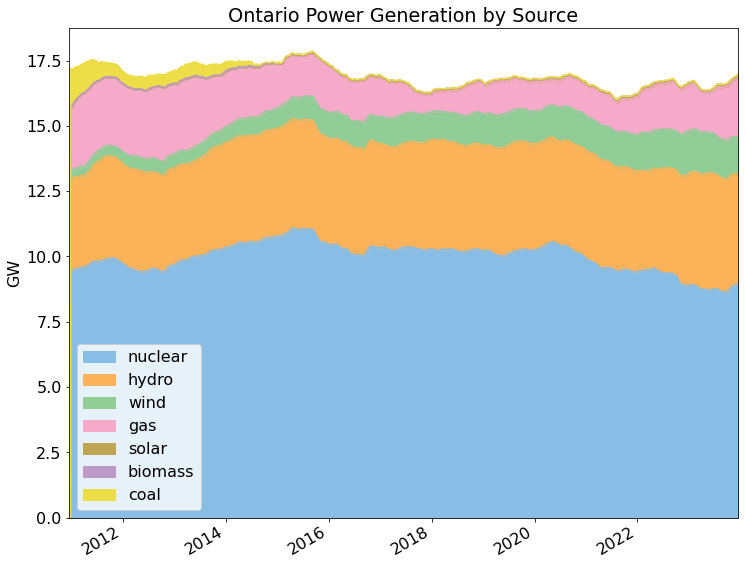

In [11]:
(df_output_by_source[["nuclear", "hydro", "wind", "gas", "solar", "biomass", "coal"]].rolling(360*24).mean() / 1e3).plot.area()
plt.xlim(np.array([600, -250]) + plt.xlim())
plt.ylabel("GW")
plt.title("Ontario Power Generation by Source");

![biomass](../images/co2signal.com/biomass.png)
![coal](../images/co2signal.com/coal.png)
![gas](../images/co2signal.com/gas.png)
![geothermal](../images/co2signal.com/geothermal.png)
![hydro](../images/co2signal.com/hydro.png)
![nuclear](../images/co2signal.com/nuclear.png)
![oil](../images/co2signal.com/oil.png)
![solar](../images/co2signal.com/solar.png)
![wind](../images/co2signal.com/wind.png)

In [12]:
df_intensity = pd.DataFrame({
    "biomass": {
        "carbon_intensity": 230,
        "source": "IPCC 2014"
    },
    "coal": {
        "carbon_intensity": 820,
        "source": "IPCC 2014"
    },
    "gas": {
        "carbon_intensity": 490,
        "source": "IPCC 2014"
    },
    "geothermal": {
        "carbon_intensity": 38,
        "source": "IPCC 2014"
    },
    "hydro": {
        "carbon_intensity": 24,
        "source": "IPCC 2014"
    },
    "nuclear": {
        "carbon_intensity": 5,
        "source": "Mallia, E., Lewis, G. 'Life cycle greenhouse gas emissions of electricity generation in the province of Ontario, Canada' (2013)"
    },
    "oil": {
        "carbon_intensity": 650,
        "source": "UK POST 2014"
    },
    "solar": {
        "carbon_intensity": 45,
        "source": "IPCC 2014"
    },
    "wind": {
        "carbon_intensity": 11,
        "source": "IPCC 2014"
    },
})
df_intensity

,biomass,coal,gas,geothermal,hydro,nuclear,oil,solar,wind
carbon_intensity,230,820,490,38,24,5,650,45,11
source,IPCC 2014,IPCC 2014,IPCC 2014,IPCC 2014,IPCC 2014,"Mallia, E., Lewis, G. 'Life cycle greenhouse g...",UK POST 2014,IPCC 2014,IPCC 2014


In [13]:
no_data_idx = df_output_by_source[df_output_by_source.sum(axis=1) == 0].index
df_output_by_source.loc[no_data_idx, df_output_by_source.columns] = np.nan
df_output_by_source = df_output_by_source.interpolate()

In [14]:
df_emissions = pd.DataFrame()
sources = df_output_by_source.columns
for source in sources:
    df_emissions[source] = df_output_by_source[source] * df_intensity.loc["carbon_intensity", source] / 1000
df_emissions["total (tCO2e)"] = df_emissions.sum(axis=1)
df_emissions["intensity (gCO2e/kWh)"] = (df_emissions[sources].sum(axis=1) / df_output_by_source.sum(axis=1)).interpolate() * 1000
df_emissions = df_emissions.rename(columns={source: f"{source} (tCO2e)" for source in sources})
df_emissions["year"] = df_emissions.index.year

(14555.510416666668, 19758.864583333336)

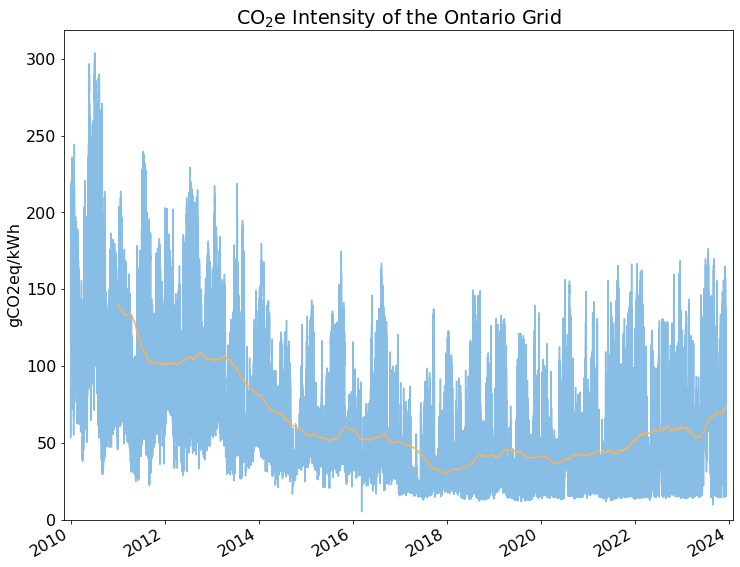

In [20]:
df_emissions["intensity (gCO2e/kWh)"].plot()
df_emissions["intensity (gCO2e/kWh)"].rolling(365*24).mean().plot()
plt.ylim([0, None])
plt.ylabel("gCO2eq/kWh")
plt.title("CO$_2$e Intensity of the Ontario Grid")
plt.xlim(np.array([200, -200]) + plt.xlim())

Text(0.5, 1.0, 'Average CO$_2$e Intensity (Ontario Grid)')

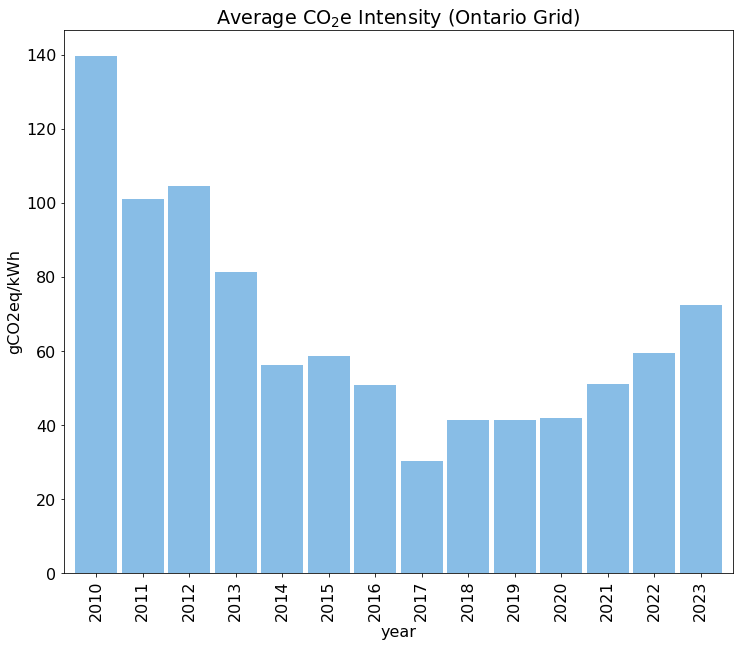

In [16]:
df_emissions_annual = df_emissions.groupby("year").sum()
df_emissions_annual["intensity (gCO2e/kWh)"] = df_emissions.groupby("year")["intensity (gCO2e/kWh)"].mean()
df_emissions_annual["intensity (gCO2e/kWh)"].plot.bar(width=0.9)
plt.ylabel("gCO2eq/kWh")
plt.xlabel("year")
plt.title("Average CO$_2$e Intensity (Ontario Grid)")

<AxesSubplot:ylabel='Frequency'>

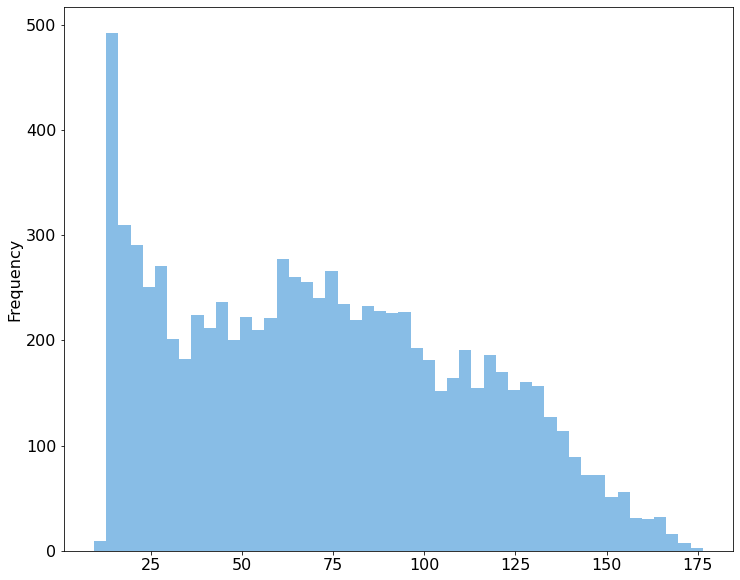

In [17]:
df_emissions["intensity (gCO2e/kWh)"].iloc[-365*24:].plot.hist(bins=50)

<AxesSubplot:xlabel='datetime'>

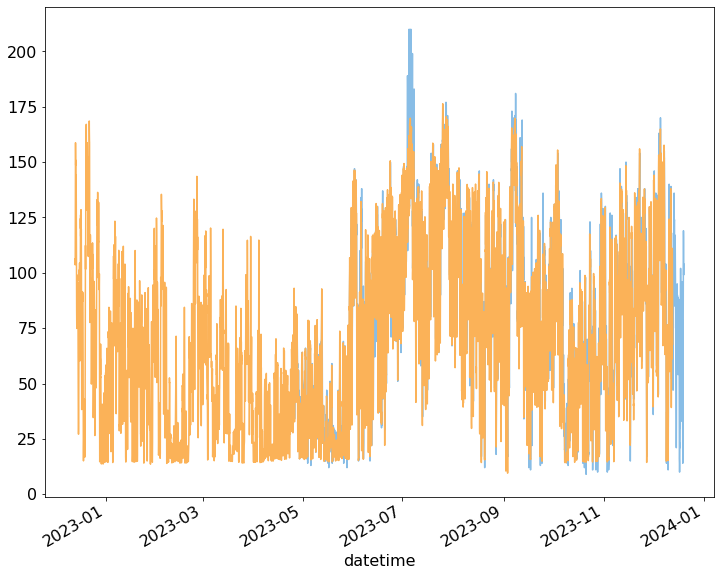

In [18]:
df_co2signal = pd.read_csv("https://raw.githubusercontent.com/ryanfobel/ontario-grid-data/main/data/clean/co2signal.com/CA-ON/hourly/output.csv", index_col=0)
df_co2signal.index = pd.to_datetime(df_co2signal.index, utc=True).tz_convert("America/Toronto")
df_co2signal = df_co2signal.sort_index(ascending=True)
df_co2signal["data.carbonIntensity"].plot()
(df_emissions["intensity (gCO2e/kWh)"]).iloc[-365*24:].plot()

In [21]:
df_emissions["hour"] = df_emissions.index.hour

print(f"mean intensity over past year = {df_emissions[(df_emissions.index > df_emissions.index[-365])]['intensity (gCO2e/kWh)'].mean():.0f} gCO2e/kWh")
ulo_intensity = df_emissions[(df_emissions["hour"] >= 23) | (df_emissions["hour"] < 7) & (df_emissions.index > df_emissions.index[-365])]["intensity (gCO2e/kWh)"].mean()
print(f"mean intensity over past year (11pm-7am) = {ulo_intensity:.0f} gCO2e/kWh")

mean intensity over past year = 96 gCO2e/kWh
mean intensity over past year (11pm-7am) = 57 gCO2e/kWh
